<a href="https://colab.research.google.com/github/Kgs-Mathaba/TensorFlow_Development_ZTM/blob/main/08_Introduction_to_NLP_in_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check GPU
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [ ]:
## Get text dataset
## Kaggle's introduction to NLP dataset
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

#Unzip data
unzip_data('nlp_getting_started.zip')

--2021-11-20 22:15:54--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.98.128, 74.125.31.128, 74.125.134.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.1’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.009s  

2021-11-20 22:15:54 (61.1 MB/s) - ‘nlp_getting_started.zip.1’ saved [607343/607343]



In [ ]:
import pandas as pd
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

In [ ]:
train_df.shape, test_df.shape

((7613, 5), (3263, 4))

In [ ]:
train_df['text'][1]

'Forest fire near La Ronge Sask. Canada'

In [ ]:
# shuffle training data
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head(10)

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# number of samples
len(train_df), len(test_df)

(7613, 3263)

In [ ]:
# visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[['text', 'target']][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f'Target: {target}', "(real diaster)" if target >0 else "(not real diaster)")
  print(f'Text:\n{text}\n')
  print('---\n')

Target: 1 (real diaster)
Text:
abcnews - Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster declaration for Northern... http://t.co/mg5eAJElul

---

Target: 0 (not real diaster)
Text:
Police walk up on me I be blowin smoke in dey face  wanna lock me up cus I got dope shit is gay

---

Target: 0 (not real diaster)
Text:
I get this feeling that society will collapse or implode. So don't be a hero and play your part.

---

Target: 0 (not real diaster)
Text:
Various issues fail to derail homes bid http://t.co/zhsLl7swBh

---

Target: 1 (real diaster)
Text:
airplane crashes on house in Colombia 12 people die in accident https://t.co/ZhJlfLBHZL

---



In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size = 0.1,
                                                                            random_state = 42)

In [ ]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
# first ten sentences
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

In [ ]:
# Convert text into numbers
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [ ]:
text_vectorizer = TextVectorization(max_tokens=None,
                                    standardize = "lower_and_strip_punctuation",
                                    split = 'whitespace',
                                    ngrams = None,
                                    output_mode = "int",
                                    output_sequence_length=None,
                                    pad_to_max_tokens = False)

In [ ]:
# Find the average number of tokens in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [ ]:
# Setup text vectorization variables
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode = 'int',
                                    output_sequence_length=max_length)

In [ ]:
# Fit the text vectorizer to the training set
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# random sentece from training set
random_sentence = random.choice(train_sentences)
print(f'Original text:\n {random_sentence}\
      \n\n Vectorized version:')
text_vectorizer([random_sentence])

Original text:
 @weathernetwork here comes the hail!      

 Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[3254,  140,  958,    2,  348,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [ ]:
# number of unique word in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f'Number of words in vocab: {len(words_in_vocab)}')
print(f'5 Most common words: {top_5_words}')
print(f'5 least common words: {bottom_5_words}')

Number of words in vocab: 10000
5 Most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [ ]:
# Create embedding layer
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim = max_vocab_length,
                             output_dim=128,
                             input_length = max_length
                             )


In [ ]:
# Get a random sentence from the taining set
random_sentence = random.choice(train_sentences)
print(f'Original text: \n {random_sentence}\
      \n \n Embedded version:')

# Embed a random sentence
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text: 
 Rather violent storm. Possibility of no stream tonight.      
 
 Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04965411,  0.0431725 , -0.03753915, ...,  0.0115926 ,
          0.01836746,  0.02179904],
        [-0.02385867, -0.00493538, -0.03195716, ..., -0.03116384,
          0.0401369 , -0.00027575],
        [-0.04834498, -0.03007923, -0.03272352, ...,  0.04578297,
         -0.03123646, -0.01701589],
        ...,
        [ 0.04066141,  0.03019423,  0.04059315, ...,  0.00245212,
          0.01252905, -0.0183207 ],
        [ 0.04066141,  0.03019423,  0.04059315, ...,  0.00245212,
          0.01252905, -0.0183207 ],
        [ 0.04066141,  0.03019423,  0.04059315, ...,  0.00245212,
          0.01252905, -0.0183207 ]]], dtype=float32)>

In [ ]:
# single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.04965411,  0.0431725 , -0.03753915,  0.01758472, -0.02945432,
        -0.04638634, -0.01082528, -0.02665453,  0.03396236,  0.04280144,
        -0.03123376, -0.03527258, -0.02008956,  0.00244535,  0.0404822 ,
        -0.03338567, -0.03813368,  0.00988029, -0.0057749 ,  0.03840145,
        -0.02609041, -0.02333322,  0.02260505,  0.0145216 , -0.04311401,
        -0.01930058,  0.03739008,  0.0266265 ,  0.00752537,  0.02513993,
         0.00851525, -0.03704184,  0.02512497,  0.04173484,  0.00838067,
        -0.0474134 , -0.00790335,  0.00044292,  0.0470388 ,  0.031071  ,
        -0.03935143, -0.01300091, -0.0337648 , -0.04354577, -0.00032537,
         0.03346325,  0.04514024, -0.02078718,  0.04352081,  0.03868834,
        -0.04873602,  0.02195618, -0.04884956,  0.03286793, -0.04697976,
        -0.00448545, -0.03560444, -0.04580866, -0.03078815, -0.01251074,
        -0.00830336,  0.03180422,  0.04748995,  0.03206699,  0.0031093 ,
  

In [ ]:
# Model 0 (Baseline model)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()),
                    ("clf", MultinomialNB()),
])

# Fit pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate model
baseline_score = model_0.score(val_sentences, val_labels)
print(f'Baseline model has accuracy of: {baseline_score*100:2f}%')

Baseline model has accuracy of: 79.265092%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)

In [ ]:
baseline_preds[:10]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0])

In [ ]:
# create an evaluation function for modelling experiments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):

  """
  Calculates model accuracy, precision, recall and f1-score for binary classification model.

  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)*100

  # Calculate model precision, recall and f1-score using wieghted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [ ]:
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred = baseline_preds)

baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [ ]:
# Model_1: A simple dense model
# Create a tensorboard callback
from helper_functions import create_tensorboard_callback

# Ctreate a directory to save a TensorBoard logs
SAVE_DIR = "model_logs"

In [ ]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding 
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
# Compile model
model_1.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20211120-221556
Epoch 1/5
215/215 [==============================] - 5s 20ms/step - loss: 0.6147 - accuracy: 0.6872 - val_loss: 0.5369 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.4438 - accuracy: 0.8175 - val_loss: 0.4693 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3482 - accuracy: 0.8616 - val_loss: 0.4593 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.2858 - accuracy: 0.8866 - val_loss: 0.4645 - val_accuracy: 0.7913
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.2386 - accuracy: 0.9107 - val_loss: 0.4771 - val_accuracy: 0.7861


In [ ]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4771 - accuracy: 0.7861


[0.47706443071365356, 0.7860892415046692]

In [ ]:
model_1_pred_probs = model_1.predict(val_sentences)

In [ ]:
model_1_pred_probs[0]

array([0.3737622], dtype=float32)

In [ ]:
# Convert model predictions probabilities to labels
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [ ]:
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred = model_1_preds)

model_1_results

{'accuracy': 78.60892388451444,
 'f1': 0.7832971347503846,
 'precision': 0.7903277546022673,
 'recall': 0.7860892388451444}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [ ]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [ ]:
# Get the vocabulary from the text vectorization
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
# Get the weight matrix of embedding layer 
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)

(10000, 128)


In [ ]:
print(embed_weights[0].shape)

(128,)


In [ ]:
# Create embedding files
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
#try:
# from google.colab import files
#  files.download('vectors.tsv')
#  files.download('metadata.tsv')
#except Exception:
#  pass

In [ ]:
# Create an LSTM model
from tensorflow.keras import layers

input = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
#print(x.shape)
#x = layers.LSTM(64, return_sequences=True)(x) # for stacking lSTMs
#print(x.shape)
x = layers.LSTM(64)(x)
#print(x.shape)
#x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_LSTM')

In [ ]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [ ]:
# Compile the model
model_2.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [ ]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data=(val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       'model_2_LSTM')])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20211120-221708
Epoch 1/5
215/215 [==============================] - 9s 32ms/step - loss: 0.2193 - accuracy: 0.9228 - val_loss: 0.5684 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 6s 29ms/step - loss: 0.1551 - accuracy: 0.9397 - val_loss: 0.6695 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 6s 30ms/step - loss: 0.1284 - accuracy: 0.9492 - val_loss: 0.7932 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 6s 29ms/step - loss: 0.1042 - accuracy: 0.9603 - val_loss: 0.8375 - val_accuracy: 0.7835
Epoch 5/5
215/215 [==============================] - 6s 29ms/step - loss: 0.0811 - accuracy: 0.9675 - val_loss: 1.0185 - val_accuracy: 0.7730


In [ ]:
# Make predictions with the LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[5.0676167e-03],
       [8.8198388e-01],
       [9.9984336e-01],
       [2.5637090e-02],
       [2.6866794e-04],
       [9.9935055e-01],
       [9.3711948e-01],
       [9.9990582e-01],
       [9.9981904e-01],
       [2.3851219e-01]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred = model_2_preds)

model_2_results

{'accuracy': 77.29658792650919,
 'f1': 0.7701512125975899,
 'precision': 0.7763206990944375,
 'recall': 0.7729658792650919}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [ ]:
## model 3: GRU (gated recurrent unit)

from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
#print(x.shape)
#x = layers.LSTM(64, return_sequences=True)(x)
#print(x.shape)
#x = layers.GRU(64)(x)
#print(x.shape)
#x = layers.Dense(64, activation='relu')(x)
#x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_GRU')

In [ ]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [ ]:
model_3.compile(loss='binary_crossentropy',
                optimizer = 'adam',
                metrics=['accuracy'])

In [ ]:
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       'model_3_GRU')])

Saving TensorBoard log files to: model_logs/model_3_GRU/20211120-221752
Epoch 1/5
215/215 [==============================] - 9s 33ms/step - loss: 0.1610 - accuracy: 0.9362 - val_loss: 0.7403 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 6s 29ms/step - loss: 0.0840 - accuracy: 0.9680 - val_loss: 0.8321 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 6s 30ms/step - loss: 0.0719 - accuracy: 0.9729 - val_loss: 1.0148 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 6s 28ms/step - loss: 0.0610 - accuracy: 0.9756 - val_loss: 0.9636 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 6s 29ms/step - loss: 0.0536 - accuracy: 0.9765 - val_loss: 1.4085 - val_accuracy: 0.7769


In [ ]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[3.6810040e-03],
       [9.4243526e-01],
       [9.9992096e-01],
       [3.5438269e-02],
       [6.3992913e-05],
       [9.9991161e-01],
       [8.7709242e-01],
       [9.9997443e-01],
       [9.9995458e-01],
       [9.9259615e-01]], dtype=float32)

In [ ]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_pred_probs[:10]

array([[3.6810040e-03],
       [9.4243526e-01],
       [9.9992096e-01],
       [3.5438269e-02],
       [6.3992913e-05],
       [9.9991161e-01],
       [8.7709242e-01],
       [9.9997443e-01],
       [9.9995458e-01],
       [9.9259615e-01]], dtype=float32)

In [ ]:
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)


model_3_results

{'accuracy': 77.69028871391076,
 'f1': 0.7753556135933601,
 'precision': 0.7777598953427995,
 'recall': 0.7769028871391076}

In [ ]:
## Model 4: Bidirectional RNN
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
#x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name = 'model_4_bidirectional')

In [ ]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [ ]:
# Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [ ]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       'model_4_bidirectional')])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20211120-221828
Epoch 1/5
215/215 [==============================] - 15s 44ms/step - loss: 0.1085 - accuracy: 0.9672 - val_loss: 0.9527 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 8s 38ms/step - loss: 0.0524 - accuracy: 0.9774 - val_loss: 1.1300 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 8s 39ms/step - loss: 0.0477 - accuracy: 0.9791 - val_loss: 1.3795 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 9s 40ms/step - loss: 0.0415 - accuracy: 0.9812 - val_loss: 1.2550 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 8s 39ms/step - loss: 0.0424 - accuracy: 0.9804 - val_loss: 1.5385 - val_accuracy: 0.7664


In [ ]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[3.7575960e-03],
       [4.0450785e-01],
       [9.9997532e-01],
       [1.9074038e-01],
       [1.1552382e-05],
       [9.9980688e-01],
       [4.0397471e-01],
       [9.9998844e-01],
       [9.9997425e-01],
       [9.9849153e-01]], dtype=float32)

In [ ]:
# Convert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [ ]:
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred = model_4_preds)

model_4_results

{'accuracy': 76.64041994750657,
 'f1': 0.7634321207489121,
 'precision': 0.7696850393700787,
 'recall': 0.7664041994750657}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [ ]:
# Test out embedding layer, Conv1D layer and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,
                        activation='relu',
                        padding="valid")

conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPooling1D()
max_pool_output = max_pool(conv_1d_output)

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [ ]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.03434573,  0.04636366, -0.00793211, ...,  0.06322958,
         -0.06602541,  0.03676286],
        [ 0.0515458 , -0.02127993,  0.02860264, ..., -0.02145631,
          0.0770238 , -0.03091694],
        [ 0.02967123,  0.00493623,  0.00899594, ..., -0.01177966,
         -0.0205944 ,  0.04418389],
        ...,
        [ 0.03503628,  0.01521958,  0.04112023, ...,  0.01782613,
         -0.01126527,  0.01159938],
        [ 0.03503628,  0.01521958,  0.04112023, ...,  0.01782613,
         -0.01126527,  0.01159938],
        [ 0.03503628,  0.01521958,  0.04112023, ...,  0.01782613,
         -0.01126527,  0.01159938]]], dtype=float32)>

In [ ]:
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
array([[[0.        , 0.        , 0.        , 0.04229419, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.04229661, 0.02544019, 0.        ,
         0.        , 0.        , 0.08292814, 0.0705004 , 0.00948695,
         0.        , 0.03471195, 0.        , 0.00249641, 0.        ,
         0.        , 0.02875681, 0.05441514, 0.        , 0.        ,
         0.01436584, 0.        ],
        [0.03194954, 0.        , 0.05598778, 0.        , 0.06876096,
         0.05949419, 0.01818084, 0.02402287, 0.01800934, 0.        ,
         0.01088157, 0.        , 0.03323901, 0.01719735, 0.02628694,
         0.05010514, 0.06151962, 0.09560668, 0.01126534, 0.00327852,
         0.00767685, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.09789171,
         0.        , 0.        ],
        [0.        , 0.03157368, 0.        , 0.    

In [ ]:
# Create a 1D convolution layer to model sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5,strides=1 ,activation='relu', padding='valid')(x)
x = layers.GlobalMaxPooling1D()(x)
# x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name = 'model_5_Conv1D')

# Complile Conv1D model
model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


In [ ]:
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_3 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_11 (Dense)            (None, 1)              

In [ ]:
# fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data = (val_sentences,val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       'Conv1D')])

Saving TensorBoard log files to: model_logs/Conv1D/20211120-221917
Epoch 1/5
215/215 [==============================] - 5s 22ms/step - loss: 0.1269 - accuracy: 0.9555 - val_loss: 0.8923 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 4s 21ms/step - loss: 0.0749 - accuracy: 0.9715 - val_loss: 0.9960 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 4s 21ms/step - loss: 0.0610 - accuracy: 0.9755 - val_loss: 1.2420 - val_accuracy: 0.7612
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0557 - accuracy: 0.9781 - val_loss: 1.1866 - val_accuracy: 0.7638
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0499 - accuracy: 0.9787 - val_loss: 1.2208 - val_accuracy: 0.7625


In [ ]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[7.6053721e-01],
       [8.4868264e-01],
       [9.9998343e-01],
       [9.0688884e-02],
       [7.9280278e-07],
       [9.9912930e-01],
       [9.8196840e-01],
       [9.9999654e-01],
       [1.0000000e+00],
       [9.8786628e-01]], dtype=float32)

In [ ]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# evaluate model5
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred = model_5_preds)

model_5_results

{'accuracy': 76.24671916010499,
 'f1': 0.7624395693498106,
 'precision': 0.7624145815146948,
 'recall': 0.7624671916010499}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [ ]:
# Model 6 : tensorflow hub pretrained model (USE feature extractor)
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you call the universal sentence encoder on a sentence, it turn it into numbers"])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589839 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874646 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787357  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195373  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [ ]:
embed_samples

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.01157025,  0.02485911,  0.02878051, ..., -0.00186124,
         0.02315822, -0.01485021],
       [ 0.03569669, -0.08161653, -0.03142678, ..., -0.05226755,
         0.03114403, -0.00885672]], dtype=float32)>

In [ ]:
sample_sentence

"There's a flood in my street!"

In [ ]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", 
                                         input_shape=[], # input can be variable length, output is a vector of length 512
                                         dtype=tf.string,
                                         trainable=False,
                                         name='USE')

In [ ]:
# Create model using sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation='relu'),
  layers.Dense(1, activation='sigmoid')
], name='model_6_USE')

# Compile model
model_6.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_12 (Dense)            (None, 64)                32832     
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'tf_hub_USE')])

Saving TensorBoard log files to: model_logs/tf_hub_USE/20211120-222011
Epoch 1/5
215/215 [==============================] - 6s 15ms/step - loss: 0.5042 - accuracy: 0.7870 - val_loss: 0.4480 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4149 - accuracy: 0.8159 - val_loss: 0.4403 - val_accuracy: 0.8045
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4005 - accuracy: 0.8257 - val_loss: 0.4404 - val_accuracy: 0.8071
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3947 - accuracy: 0.8241 - val_loss: 0.4320 - val_accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3878 - accuracy: 0.8304 - val_loss: 0.4330 - val_accuracy: 0.8110


In [ ]:
# make predictions with USE model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.15820342],
       [0.78767   ],
       [0.98606753],
       [0.19689041],
       [0.7053982 ],
       [0.6974067 ],
       [0.979506  ],
       [0.975726  ],
       [0.92704594],
       [0.08824998]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# model_6 results
model_6_results = calculate_results(y_true = val_labels,
                                    y_pred = model_6_preds)

model_6_results

{'accuracy': 81.10236220472441,
 'f1': 0.808861008528807,
 'precision': 0.8151676782160472,
 'recall': 0.8110236220472441}

In [ ]:
# Model_7: TF Hub with pretrained USE on only 10 percent of the data
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
train_10_precent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
train_sentences_10_precent = train_10_precent["text"].to_list()
train_labels_10_precent = train_10_precent['target'].to_list()

In [ ]:
len(train_df_shuffled), len(train_10_precent)

(7613, 761)

In [ ]:
# Check the number of targets inout subset of data
train_10_precent['target'].value_counts()

0    413
1    348
Name: target, dtype: int64

In [ ]:
train_df_shuffled['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# Clone model_6
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_12 (Dense)            (None, 64)                32832     
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_7_history = model_7.fit(train_sentences_10_precent,
                              train_labels_10_precent,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'tf_hub_USE_10_percent')])

Saving TensorBoard log files to: model_logs/tf_hub_USE_10_percent/20211120-224331
Epoch 1/5
22/22 [==============================] - 4s 53ms/step - loss: 0.6687 - accuracy: 0.6292 - val_loss: 0.6491 - val_accuracy: 0.6719
Epoch 2/5
22/22 [==============================] - 1s 23ms/step - loss: 0.5970 - accuracy: 0.8102 - val_loss: 0.5907 - val_accuracy: 0.7559
Epoch 3/5
22/22 [==============================] - 1s 24ms/step - loss: 0.5231 - accuracy: 0.8234 - val_loss: 0.5379 - val_accuracy: 0.7730
Epoch 4/5
22/22 [==============================] - 1s 24ms/step - loss: 0.4606 - accuracy: 0.8292 - val_loss: 0.5062 - val_accuracy: 0.7730
Epoch 5/5
22/22 [==============================] - 1s 27ms/step - loss: 0.4189 - accuracy: 0.8350 - val_loss: 0.4920 - val_accuracy: 0.7730


In [ ]:
# make predictions with USE model
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.22843018],
       [0.58408225],
       [0.8949922 ],
       [0.3509292 ],
       [0.5368427 ],
       [0.6828155 ],
       [0.8840147 ],
       [0.78805053],
       [0.8402579 ],
       [0.15830982]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# model_7 results
model_7_results = calculate_results(y_true = val_labels,
                                    y_pred = model_7_preds)

model_7_results

{'accuracy': 77.29658792650919,
 'f1': 0.7716665369372698,
 'precision': 0.7733211200948874,
 'recall': 0.7729658792650919}

In [ ]:
model_6_results

{'accuracy': 81.10236220472441,
 'f1': 0.808861008528807,
 'precision': 0.8151676782160472,
 'recall': 0.8110236220472441}

In [ ]:
# Fixing the data leakage of the 10 percent data
train_10_precent_split = int(0.1*len(train_sentences))
train_sentences_10_precent = train_sentences[:train_10_precent_split]
train_labels_10_precent = train_labels[:train_10_precent_split]

In [ ]:
train_df_shuffled['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
model_7_history = model_7.fit(train_sentences_10_precent,
                              train_labels_10_precent,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'tf_hub_USE_10_percent_fixed')])

Saving TensorBoard log files to: model_logs/tf_hub_USE_10_percent_fixed/20211120-224243
Epoch 1/5
22/22 [==============================] - 1s 24ms/step - loss: 0.3968 - accuracy: 0.8482 - val_loss: 0.4879 - val_accuracy: 0.7795
Epoch 2/5
22/22 [==============================] - 1s 24ms/step - loss: 0.3753 - accuracy: 0.8511 - val_loss: 0.4877 - val_accuracy: 0.7795
Epoch 3/5
22/22 [==============================] - 0s 23ms/step - loss: 0.3570 - accuracy: 0.8540 - val_loss: 0.4898 - val_accuracy: 0.7795
Epoch 4/5
22/22 [==============================] - 0s 23ms/step - loss: 0.3417 - accuracy: 0.8628 - val_loss: 0.4901 - val_accuracy: 0.7756
Epoch 5/5
22/22 [==============================] - 1s 27ms/step - loss: 0.3278 - accuracy: 0.8672 - val_loss: 0.4966 - val_accuracy: 0.7703


In [ ]:
# Comparing the perfomance of each of the models
# Combine model results into dataframe
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub": model_6_results,
                                  "7_tf_hub_10_percent": model_7_results})
all_model_results = all_model_results.transpose()

In [ ]:
# Reduce accuracy to the same scale as the other metrics
all_model_results['accuracy'] = all_model_results['accuracy']/100

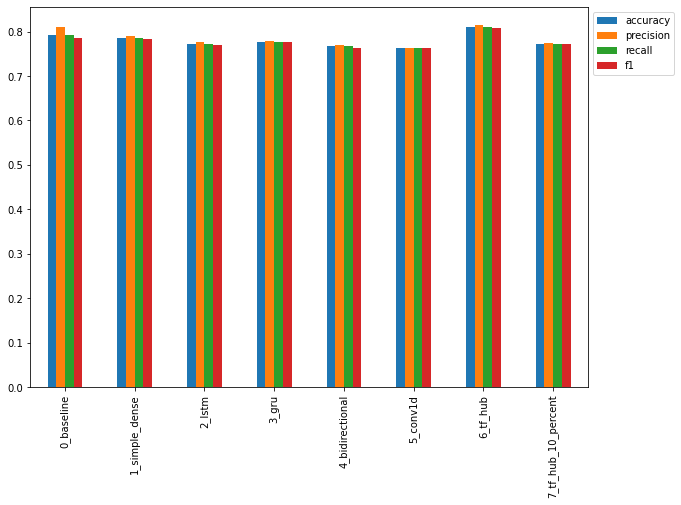

In [ ]:
#Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

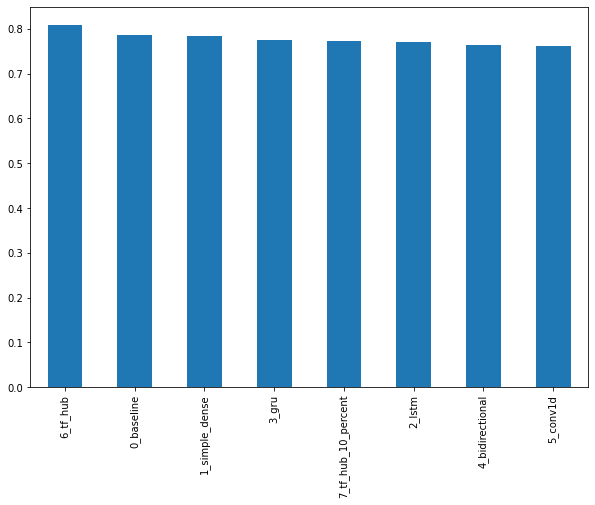

In [ ]:
# Sort model results by f1-score 
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7))

In [ ]:
# Veiw tensorboard logs
# Upload tensorboard logs
!tensorboard dev upload --logdir /content/model_logs \
 --name "NLP Modelling experiments" \
 --description "Comparing multiple type of model architecture ofr tweet classification" \
 --one_shot

2021-11-20 23:15:43.548637: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/yPIec23zQAuGQnJbJcwEdw/

[2021-11-20T23:15:43] Started scanning logdir.
[2021-11-20T23:16:03] Total uploaded: 600 scalars, 0 tensors, 20 binary objects (10.8 MB)
[2021-11-20T23:16:03] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/yPIec23zQAuGQnJbJcwEdw/


In [ ]:
# Saving and loading a NLP model
model_6.save("model_6.h5")

In [ ]:
# Load model with custom hub layer
loaded_model_6  = tf.keras.models.load_model("model_6.h5",
                                             custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 12ms/step - loss: 0.4330 - accuracy: 0.8110


[0.43297335505485535, 0.8110235929489136]

In [ ]:
# Save to `SavedModel` format
model_6.save("Model_6_SavedModel_format")

INFO:tensorflow:Assets written to: Model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: Model_6_SavedModel_format/assets


In [ ]:
# load SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("Model_6_SavedModel_format")

In [ ]:
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 12ms/step - loss: 0.4330 - accuracy: 0.8110


[0.43297335505485535, 0.8110235929489136]

In [ ]:
# Find the most wrong examples
# Create DataFrame with validation sentence and best performing
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2021-11-20 23:57:47--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.128, 173.194.216.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M   142MB/s    in 5.7s    

2021-11-20 23:57:53 (161 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variable

In [ ]:
# Import prviously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 12ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [ ]:
# Make predictions with the loaded model
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Create Dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [ ]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df['target'] !=val_df['pred']].sort_values("pred_prob", ascending=False)
most_wrong.head()

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213


In [ ]:
most_wrong.tail()

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [ ]:
# 0 = not disaster
# 1 =  disaster
# check the false positive (model predicted 1 when actual 0)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n {text}\n")
  print("----\n")

Target: 1, Pred: 0.0, Prob: 0.06730341911315918
Text:
 @DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0.0, Prob: 0.05507585406303406
Text:
 @willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0, Prob: 0.054603397846221924
Text:
 Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0, Prob: 0.05459702014923096
Text:
 going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0, Prob: 0.04963722825050354
Text:
 You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0, Prob: 0.043918460607528687
Text:
 @SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0.0, Pr

In [ ]:
# Making predictions on the test dataset and visualizing
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)

for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # model expects list as input
  pred = tf.round(pred_prob)
  print(f'Pred: {int(pred)}, Prob: {pred_prob}')
  print(f'Text:\n{test_sample}\n')
  print("-----\n")

Pred: 0, Prob: 0.2251836359500885
Text:
Permutable site conspiracy up-to-the-minute upheaval: QWkD

-----

Pred: 0, Prob: 0.11811554431915283
Text:
First responders tell me he is lucky.... had someone riding with him today. http://t.co/jc16CZn0NC

-----

Pred: 1, Prob: 0.9162265658378601
Text:
#environment Lone Pine trees growing across the country in remembrance of battle at Gallipoli 100 years ago: T... http://t.co/GJCAAnfCYk

-----

Pred: 0, Prob: 0.13414719700813293
Text:
@PeterArnottGlas I've written a play about Dr Rae and his destruction by Lady Franklin as it happens.  Commissioned by Mull Theatre

-----

Pred: 0, Prob: 0.059100836515426636
Text:
#Nickelodeon paw patrol-- rubble #action pack pup &amp; #badge  LINK:
http://t.co/N7tG7RoAmU http://t.co/U12hHyu1dc

-----

Pred: 1, Prob: 0.7933599948883057
Text:
WAS Times: PawSox owners public return from whirlwind trip to Durham http://t.co/07nKMO7VaS

-----

Pred: 0, Prob: 0.16479113698005676
Text:
@Brandon_Warne MLB has that ball

In [ ]:
# Make function that measure the time it takes to make prediction
import time
def pred_timer(model, samples):
  """

  Times how long  model takes to make a prediction on samples
  """

  start_time = time.perf_counter() # get start time
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time - start_time 
  time_per_prediction = total_time/len(samples)

  return total_time, time_per_prediction

In [ ]:
# Calculate how long model 6 take to make predictions
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                            samples=val_sentences)

model_6_total_pred_time, model_6_time_per_pred 

(0.34928730100000394, 0.00045838228477690807)

In [ ]:
# Calculate how long model 6 take to make predictions
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model=model_0,
                                                            samples=val_sentences)

baseline_total_pred_time, baseline_time_per_pred

(0.03339279899955727, 4.382257086556072e-05)

In [ ]:
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                               y_pred = model_6_pretrained_preds)

model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'f1': 0.8148082644367335,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

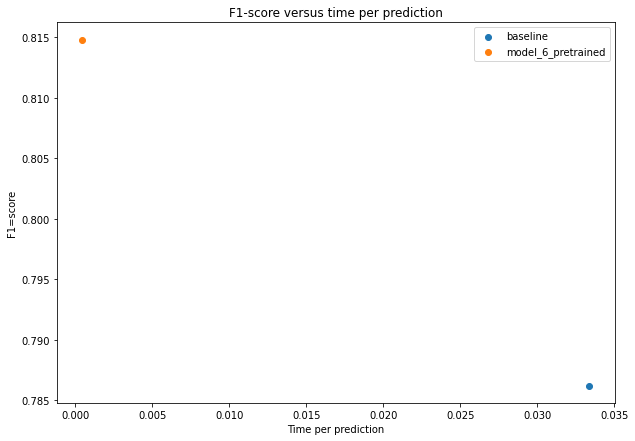

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(baseline_total_pred_time, baseline_results['f1'], label='baseline')
plt.scatter(model_6_time_per_pred, model_6_pretrained_results['f1'], label='model_6_pretrained')
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1=score");